In [25]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns
import os

from sklearn.datasets import fetch_covtype
import torchvision
import torchvision.transforms as transforms
import torch

from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tqdm
from baselineClassifierNN import SimpleMLP
from DynamicClassifierNN import DynamicMLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from itertools import product
import json
from training import train_complex_model, train_model, plot_learning_curves

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [26]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
rcParams['axes.labelsize'] = 12  # Academic font size for axis labels
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['axes.titlesize'] = 14
figsize = (8, 6) 

In [27]:
data_dir = "../data"
results_dir = "../results"

# Get datasets section

### Covtype dataset

In [28]:
data_cov = fetch_covtype(as_frame=True)
df_covtype = data_cov.frame 

df_covtype['Cover_Type'] = df_covtype['Cover_Type'] - 1
df_covtype['Aspect_sin'] = np.sin(np.deg2rad(df_covtype['Aspect']))
df_covtype['Aspect_cos'] = np.cos(np.deg2rad(df_covtype['Aspect']))
df_covtype = df_covtype.drop(columns=['Aspect'])


X_cov_type = df_covtype.drop('Cover_Type', axis=1).values
y_cov_type = df_covtype['Cover_Type'].values

print("Covtype dataset loaded.")
print(f"Covtype features shape: {X_cov_type.shape}, Covtype labels shape: {y_cov_type.shape}")

Covtype dataset loaded.
Covtype features shape: (581012, 55), Covtype labels shape: (581012,)


In [29]:
df_covtype.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,2596.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.777146,0.629320
1,2590.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.829038,0.559193
2,2804.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.656059,-0.754710
3,2785.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.422618,-0.906308
4,2595.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.707107,0.707107


### Fashion-MNIST dataset

In [ ]:

# Download and load Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True,  
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Convert train_dataset to DataFrame
train_images = []
train_labels = []

for img, label in train_dataset:
    train_images.append(img.numpy().flatten())
    train_labels.append(label)

df_train_fashion = pd.DataFrame(train_images)
df_train_fashion['label'] = train_labels

# Convert test_dataset to DataFrame
test_images = []
test_labels = []

for img, label in test_dataset:
    test_images.append(img.numpy().flatten())
    test_labels.append(label)

df_test_fashion = pd.DataFrame(test_images)
df_test_fashion['label'] = test_labels

print("Fashion-MNIST dataset loaded.")
print(f"Fashion-MNIST train shape: {df_train_fashion.shape}, Fashion-MNIST test shape: {df_test_fashion.shape}")
df_train_fashion.head()


In [ ]:
# what is the class distribution for each dataset
print("Covtype class distribution:\n", pd.Series(y_cov_type).value_counts().sort_index())
print("Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Covtype class distribution:
 0    211840
1    283301
2     35754
3      2747
4      9493
5     17367
6     20510
Name: count, dtype: int64
Fashion-MNIST class distribution:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [ ]:
# take away 1000 entries from class label 0 in fashion mnist
for i in range(0, 10):
    index_to_drop = df_train_fashion[df_train_fashion['label'] == i].index[0]
    df_train_fashion = df_train_fashion.drop(df_train_fashion[df_train_fashion['label'] == i].index[:500*i])
print("Updated Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Updated Fashion-MNIST class distribution:
 label
0    6000
1    5500
2    5000
3    4500
4    4000
5    3500
6    3000
7    2500
8    2000
9    1500
Name: count, dtype: int64


### Prepare each dataset for training and testing

### Covtype dataset

In [ ]:
# take df_cover and build a single data frame for train and test. Have a 70-30 split. 
df_shuffled = df_covtype.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.7 * len(df_shuffled))

# Split into train and test
df_train_cov = df_shuffled.iloc[:split_idx].copy()
df_test_cov = df_shuffled.iloc[split_idx:].copy()
df_validation_cov = df_train_cov.sample(frac=0.3, random_state=42)
df_train_cov = df_train_cov.drop(index=df_validation_cov.index).reset_index(drop=True)
df_validation_cov = df_validation_cov.reset_index(drop=True)
df_test_cov = df_test_cov.reset_index(drop=True)

df_train_cov.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,2732.0,7.0,212.0,1.0,1082.0,231.0,236.0,137.0,912.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.777146,-0.629320
1,2824.0,13.0,417.0,39.0,3223.0,233.0,214.0,110.0,6478.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.933580,0.358368
2,2529.0,5.0,120.0,9.0,1092.0,227.0,231.0,139.0,4983.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994522,0.104528
3,2050.0,42.0,170.0,141.0,192.0,75.0,201.0,246.0,255.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,-0.970296,0.241922
4,3141.0,6.0,503.0,72.0,240.0,228.0,241.0,147.0,1354.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.406737,-0.913545


In [ ]:
scaler = StandardScaler()
df_train_cov_scaled = scaler.fit_transform(df_train_cov.drop('Cover_Type', axis=1))
df_test_cov_scaled = scaler.transform(df_test_cov.drop('Cover_Type', axis=1))
df_validation_cov_scaled = scaler.transform(df_validation_cov.drop('Cover_Type', axis=1))

df_train_cov_scaled = pd.DataFrame(df_train_cov_scaled, columns=df_train_cov.drop('Cover_Type', axis=1).columns)
df_train_cov_scaled['label'] = df_train_cov['Cover_Type'].values
df_validation_cov_scaled = pd.DataFrame(df_validation_cov_scaled, columns=df_validation_cov.drop('Cover_Type', axis=1).columns)
df_validation_cov_scaled['label'] = df_validation_cov['Cover_Type'].values
df_test_cov_scaled = pd.DataFrame(df_test_cov_scaled, columns=df_test_cov.drop('Cover_Type', axis=1).columns)
df_test_cov_scaled['label'] = df_test_cov['Cover_Type'].values

X_train_cov = torch.tensor(df_train_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_train_cov = torch.tensor(df_train_cov_scaled['label'].values, dtype=torch.long).to(device)

X_validation_cov = torch.tensor(df_validation_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation_cov = torch.tensor(df_validation_cov_scaled['label'].values, dtype=torch.long).to(device)

X_test_cov = torch.tensor(df_test_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_test_cov = torch.tensor(df_test_cov_scaled["label"].values, dtype=torch.long).to(device)



print("Covtype train and test DataFrames created.")
print(f"Covtype train shape: {df_train_cov_scaled.shape}, Covtype test shape: {df_test_cov_scaled.shape}, Covtype validation shape: {df_validation_cov_scaled.shape}")
df_train_cov_scaled.head()

Covtype train and test DataFrames created.
Covtype train shape: (284696, 56), Covtype test shape: (174304, 56), Covtype validation shape: (122012, 56)


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label
0,-0.810111,-0.947044,-0.267767,-0.779034,-0.811772,0.705564,0.641559,-0.147932,-0.806385,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.875461,-1.168007,1
1,-0.481563,-0.147008,0.697251,-0.126014,0.562346,0.780021,-0.472742,-0.853676,3.406391,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.106044,0.264724,1
2,-1.535061,-1.213723,-0.700849,-0.641556,-0.805354,0.556648,0.388309,-0.095655,2.274861,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.195871,-0.103493,1
3,-3.245657,3.719833,-0.465478,1.626829,-1.382984,-5.102140,-1.131192,2.701184,-1.303653,-0.901667,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-1.700256,0.095809,2
4,0.650502,-1.080384,1.102088,0.441083,-1.352177,0.593877,0.894809,0.113455,-0.471845,1.109057,...,-0.05325,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.329480,-1.580302,1


### Fashion-MNIST dataset

In [ ]:
X_train_fashion_init = df_train_fashion.drop('label', axis=1)
y_train_fashion = df_train_fashion['label']

X_train_fashion_final, X_validation_fashion_final, y_train_fashion_final, y_validation_fashion_final = train_test_split(X_train_fashion_init, y_train_fashion, test_size=0.3, random_state=42)

X_test_fashion_init = df_test_fashion.drop('label', axis=1)
y_test_fashion = df_test_fashion['label']

X_train_fashion = torch.tensor(X_train_fashion_final.values, dtype=torch.float32).to(device)
y_train_fashion = torch.tensor(y_train_fashion_final.values, dtype=torch.long).to(device)
X_validation_fashion = torch.tensor(X_validation_fashion_final.values, dtype=torch.float32).to(device)
y_validation_fashion = torch.tensor(y_validation_fashion_final.values, dtype=torch.long).to(device)
X_test_fashion = torch.tensor(X_test_fashion_init.values, dtype=torch.float32).to(device)
y_test_fashion = torch.tensor(y_test_fashion.values, dtype=torch.long).to(device)

### train baseline model

In [ ]:
# 'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (150, 100, 50, 25)]
param_grid = {
    'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64),
        (200, 150, 100, 50),
        (256, 128, 64, 32),     
        (512, 256, 128, 64),  
        (128, 128, 128, 128),     
        (300, 200, 100, 50),  ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [300]
}

In [ ]:
def grid_search_params(X_train, y_train, X_test, y_test, param_grid):
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train))

    results = []

    for hidden_layers, activation, lr, epochs in product(
        param_grid['hidden_layers'],
        param_grid['activation'],
        param_grid['lr'],
        param_grid['epochs']
    ):
        model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) if activation == 'relu' else optim.SGD(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_test).argmax(dim=1)
            acc = accuracy_score(y_test.cpu(), preds.cpu())
        results.append({
            'hidden_layers': hidden_layers,
            'activation': activation,
            'lr': lr,
            'epochs': epochs,
            'accuracy': acc
        })

    # Display top 5 results
    results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    print(results_df.head())

In [ ]:
# grid_search_params(X_train_cov, y_train_cov, X_test_cov, y_test_cov, param_grid)

In [ ]:
# grid_search_params(X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion, param_grid)

In [ ]:
optimal_params_cov = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.01,
}
optimal_params_fashion = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.005,

}

#### covtype model training and evaluation

Training Progress: 100%|██████████| 200/200 [20:52<00:00,  6.26s/it]


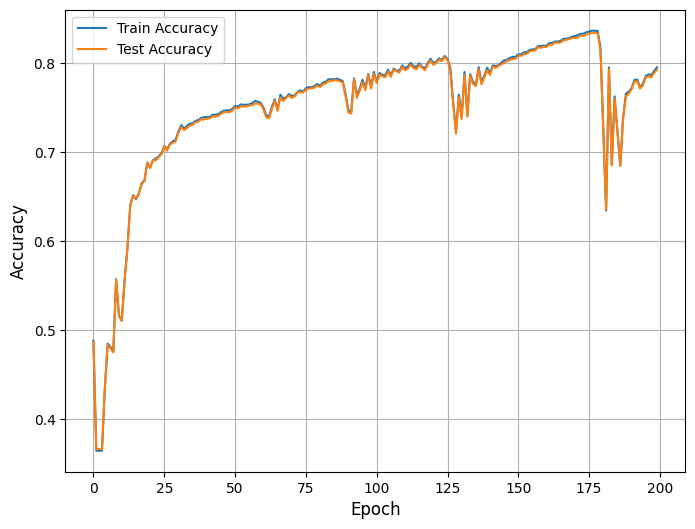

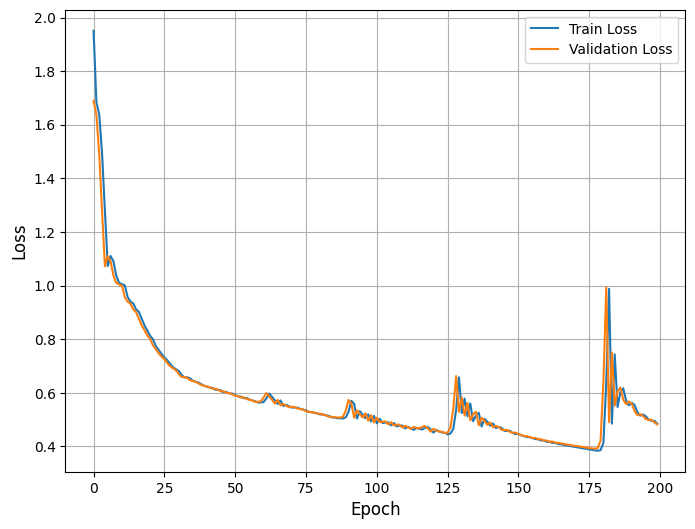

In [ ]:
input_dim_cov = X_train_cov.shape[1]
output_dim_cov = len(torch.unique(y_train_cov))
hidden_layers_cov = optimal_params_cov['hidden_layers']
activation_cov = optimal_params_cov['activation']

model_cov = SimpleMLP(input_dim_cov, hidden_layers_cov, output_dim_cov, activation_cov).to(device)
optimizer_cov = torch.optim.Adam(model_cov.parameters(), lr=optimal_params_cov['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, test_losses = train_model(model_cov, optimizer_cov, criterion, X_train_cov, y_train_cov, X_validation_cov, y_validation_cov, epochs=200)
plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Covtype Model Learning Curves")

#### fashion-mnist training and evaluation

Training Progress: 100%|██████████| 400/400 [01:59<00:00,  3.34it/s]


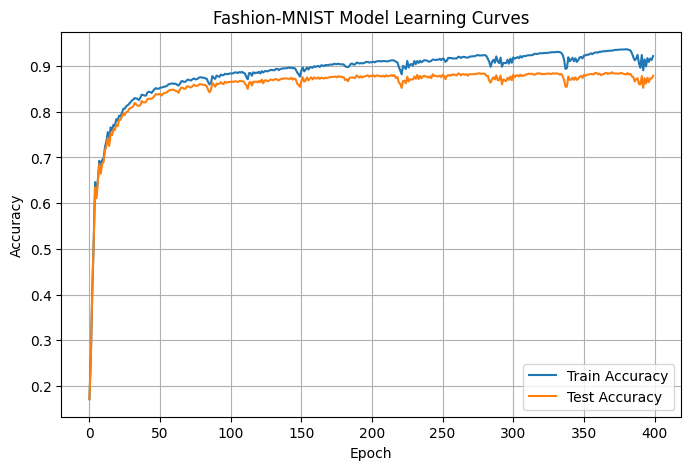

In [ ]:
input_dim_fashion = X_train_fashion.shape[1]
output_dim_fashion = len(torch.unique(y_train_fashion))
hidden_layers_fashion = optimal_params_fashion['hidden_layers']
activation_fashion = optimal_params_fashion['activation']

model_fashion = SimpleMLP(input_dim_fashion, hidden_layers_fashion, output_dim_fashion, activation_fashion).to(device)
optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=optimal_params_fashion['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, test_losses = train_model(model_fashion, optimizer_fashion, criterion, X_train_fashion, y_train_fashion, X_validation_fashion, y_validation_fashion, epochs=400)
plot_learning_curves(train_acc, test_acc, train_losses, test_losses, title="Fashion-MNIST Model Learning Curves")

### training for dynamic model

In [ ]:
# assign a stable orig_uid to each source DataFrame row so we can detect overlap when concatenating later
def ensure_orig_uid(df):
    if 'orig_uid' not in df.columns:
        df = df.reset_index(drop=True).copy()
        # df['orig_uid'] = df.index.map(lambda i: f"src_{id(df)}_{i}")
    return df

dfs_cov_all_train = [ensure_orig_uid(df_train_cov_scaled[df_train_cov_scaled['label'] == i].reset_index(drop=True)) for i in range(7)]
dfs_fashion_all_train = [ensure_orig_uid(df_train_fashion[df_train_fashion['label'] == i].reset_index(drop=True)) for i in range(10)]

dfs_cov_all_train[0]

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label,orig_uid
0,0.011260,-0.013669,-0.559627,-0.452524,2.102051,-0.076243,-0.725992,-0.252487,1.355255,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.258185,1.099122,0,src_126360408283024_0
1,0.757637,0.253010,-0.441941,-0.022905,0.488538,1.263997,0.135059,-1.036647,1.264430,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.966147,-1.045169,0,src_126360408283024_1
2,0.186248,-1.080384,-1.068026,-0.710295,0.574540,0.221588,0.185709,0.061177,-0.619436,-0.901667,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.444559,1.013594,0,src_126360408283024_2
3,0.907627,0.386349,1.751710,1.403428,0.497523,0.184360,-1.181842,-0.775260,-0.075242,-0.901667,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.617024,0.903372,0,src_126360408283024_3
4,0.996906,0.253010,0.287706,0.922255,-0.368922,1.263997,-0.270142,-1.219618,0.449274,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,6.42426,-0.123236,1.153721,-0.630562,0,src_126360408283024_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103819,0.879057,-1.613741,-1.265738,-0.796218,0.454522,0.407733,0.742859,0.218010,2.250641,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.772223,-1.280844,0,src_126360408283024_103819
103820,-0.527988,-1.080384,-0.164205,0.733223,0.571973,0.072673,0.236359,0.218010,3.184626,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.011204,1.168818,0,src_126360408283024_103820
103821,0.886200,-0.147008,1.262139,0.114573,-0.730262,-0.597447,-0.219492,0.505535,0.387967,-0.901667,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-0.601623,1.158291,0,src_126360408283024_103821
103822,0.814776,0.253010,-0.950341,-0.538447,1.132916,-1.490940,0.641559,1.603360,-0.484712,-0.901667,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-1.663734,0.217145,0,src_126360408283024_103822


In [ ]:
dfs_cov_all_train[1]

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label,orig_uid
0,-0.810111,-0.947044,-0.267767,-0.779034,-0.811772,0.705564,0.641559,-0.147932,-0.806385,-0.901667,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.875461,-1.168007,1,src_126360408291424_0
1,-0.481563,-0.147008,0.697251,-0.126014,0.562346,0.780021,-0.472742,-0.853676,3.406391,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.106044,0.264724,1,src_126360408291424_1
2,-1.535061,-1.213723,-0.700849,-0.641556,-0.805354,0.556648,0.388309,-0.095655,2.274861,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,1.195871,-0.103493,1,src_126360408291424_2
3,0.650502,-1.080384,1.102088,0.441083,-1.352177,0.593877,0.894809,0.113455,-0.471845,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.329480,-1.580302,1,src_126360408291424_3
4,-1.552917,-0.947044,-1.124515,-0.744664,-1.101871,0.296046,0.084409,-0.043377,-1.269593,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.596344,0.918432,1,src_126360408291424_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138575,-0.270863,-0.813705,-1.068026,-0.744664,2.402419,0.109902,-0.016891,0.061177,1.972110,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.258185,1.099122,1,src_126360408291424_138575
138576,0.121967,1.053046,0.433636,0.458267,1.568064,-2.086601,-0.219492,1.524944,-0.088109,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-1.382483,0.696552,1,src_126360408291424_138576
138577,-0.781542,-0.013669,-1.068026,-0.710295,0.045688,0.370504,1.300009,0.374842,-0.863907,-0.901667,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,-0.424121,-1.697765,1,src_126360408291424_138577
138578,-0.156585,0.519688,-0.818534,-0.349415,0.931387,1.263997,0.185709,-1.062786,0.497714,1.109057,...,-0.057709,-0.01285,-0.022652,-0.166617,-0.15566,-0.123236,0.859097,-1.187543,1,src_126360408291424_138578


In [ ]:
# sort the dataframes list by the size of each dataframe in ascending order
# Before sorting and relabeling, ensure each class DataFrame has orig_uid for overlap checks
dfs_cov_all_train = [ensure_orig_uid(df) for df in dfs_cov_all_train]
dfs_cov_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_cov = [df['label'].iloc[0] for df in dfs_cov_all_train]
range_cov = range(0, len(sorted_label_order_cov))
label_map_cov = dict(zip(sorted_label_order_cov, range_cov))
print(f" ie class with label 1 is mapped to {label_map_cov[1]}")

print(f"label order map for covtype: {label_map_cov}")
dfs_cov_all_train = [df.assign(label=label_map_cov[df['label'].iloc[0]]) for df in dfs_cov_all_train]
dfs_cov_all_validation = [df_validation_cov_scaled[df_validation_cov_scaled['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in sorted_label_order_cov]

print("DataFrames sorted by class size.")
print(f"Size of each class in Covtype train: {[len(df) for df in dfs_cov_all_train]}")
print(f"Label for covtype order: {sorted_label_order_cov}")
print(f"Example entries from class 1 train:\n{dfs_cov_all_train[0].head()} and class 1 test:\n{dfs_cov_all_validation[0].head()}")
print(f"Example entries from class 5 train:\n{dfs_cov_all_train[4].head()} and class 5 test:\n{dfs_cov_all_validation[4].head()}")

 ie class with label 1 is mapped to 6
label order map for covtype: {np.int32(3): 0, np.int32(4): 1, np.int32(5): 2, np.int32(6): 3, np.int32(2): 4, np.int32(0): 5, np.int32(1): 6}
DataFrames sorted by class size.
Size of each class in Covtype train: [1324, 4690, 8467, 10079, 17732, 103824, 138580]
Label for covtype order: [np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(2), np.int32(0), np.int32(1)]
Example entries from class 1 train:
   Elevation     Slope  Horizontal_Distance_To_Hydrology  \
0  -3.249228  1.319725                         -1.265738   
1  -2.824258 -0.013669                         -1.124515   
2  -3.367077  1.719743                         -1.124515   
3  -2.931393  2.519779                         -0.950341   
4  -2.538563  1.586403                         -0.503138   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.796218                        -1.198142   
1                       -0.933696              

In [ ]:
# Split Fashion-MNIST train set into train and validation (30% validation)
# Keep copies and indices so dropping works correctly
df_train_fashion = df_train_fashion.copy()
# sample validation rows from the training set (indices are from df_train_fashion)
df_fashion_validation = df_train_fashion.sample(frac=0.3, random_state=42)
# drop the validation rows from the train set using their original indices
df_train_fashion = df_train_fashion.drop(index=df_fashion_validation.index).reset_index(drop=True)
# reset indices for validation and test for downstream use
df_fashion_validation = df_fashion_validation.reset_index(drop=True)
df_test_fashion = df_test_fashion.reset_index(drop=True)
print(f"Fashion-MNIST validation shape: {df_fashion_validation.shape}, test shape: {df_test_fashion.shape}")

# sort the dataframes list by the size of each dataframe in ascending order
# Ensure orig_uid present for fashion class dfs
dfs_fashion_all_train = [ensure_orig_uid(df) for df in dfs_fashion_all_train]
dfs_fashion_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_fashion = [df['label'].iloc[0] for df in dfs_fashion_all_train]
range_fashion = range(0, len(sorted_label_order_fashion))
label_map_fashion = dict(zip(sorted_label_order_fashion, range_fashion))

print(f"label order map for fashion: {label_map_fashion}")
# assign the value from the map to the train and test set label
dfs_fashion_all_train = [df.assign(label=label_map_fashion[df['label'].iloc[0]]) for df in dfs_fashion_all_train]
dfs_fashion_all_validation = [df_fashion_validation[df_fashion_validation['label'] == lbl].assign(label=label_map_fashion[lbl]) for lbl in sorted_label_order_fashion]

print("DataFrames sorted by class size.")
print(f"Size of each class in Fashion MNIST train: {[len(df) for df in dfs_fashion_all_train]}")
print(f"Label for fashion order: {sorted_label_order_fashion}")
print(f"Example entries from class 1 train:\n{dfs_fashion_all_train[0].head()} and class 1 validation:\n{dfs_fashion_all_validation[0].head()}")
print(f"Example entries from class 5 train:\n{dfs_fashion_all_train[4].head()} and class 5 validation:\n{dfs_fashion_all_validation[4].head()}")


Fashion-MNIST validation shape: (11250, 785), test shape: (10000, 785)
label order map for fashion: {np.int64(9): 0, np.int64(8): 1, np.int64(7): 2, np.int64(6): 3, np.int64(5): 4, np.int64(4): 5, np.int64(3): 6, np.int64(2): 7, np.int64(1): 8, np.int64(0): 9}
DataFrames sorted by class size.
Size of each class in Fashion MNIST train: [1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
Label for fashion order: [np.int64(9), np.int64(8), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0)]
Example entries from class 1 train:
     0    1    2    3    4    5    6    7    8    9  ...  776  777  778  779  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.

In [ ]:
# def train_complex_model(model, optimizer, criterion, parameters, all_train_dfs, all_test_dfs, label='label', epochs=50):
#     device = next(model.parameters()).device
#     train_acc = []
#     test_acc = []
#     train_losses = []
#     val_losses = []
#     look_back = 30

#     has_underfit = False
#     has_overfit = False
#     has_plateaued = False
#     lock = False
#     lock_epochs = 0

#     X_train, y_train, X_test, y_test = None, None, None, None
#     current_class_index = 2  # start from the third class since first two are combined initially
#     num_plateued = 0
#     goal_classes = len(all_train_dfs) - 1  # last valid index
#     final_dataset_reached = False
#     final_plateau_count = 0
#     print(f"Goal classes to achieve (last index): {goal_classes}")

#     def combine_new_class_to_dataset(new_class_df_train, new_class_df_test):
#         nonlocal X_train, y_train, X_test, y_test
#         # new_class_df_* are expected to have the same columns: [feature1,..,featureN, label]
#         if X_train is None or y_train is None:
#             combined_train_df = new_class_df_train.copy()
#             combined_test_df = new_class_df_test.copy()
#         else:
#             # determine feature column names from the new class df (exclude label)
#             feature_cols = list(new_class_df_train.drop(columns=[label]).columns)

#             # move tensors to CPU and convert to numpy safely
#             Xtr = X_train.detach().cpu().numpy()
#             ytr = y_train.detach().cpu().numpy()
#             Xte = X_test.detach().cpu().numpy()
#             yte = y_test.detach().cpu().numpy()

#             # build DataFrames that match the same column layout as new_class_df_train
#             train_features = pd.DataFrame(Xtr, columns=feature_cols)
#             train_labels = pd.Series(ytr.flatten(), name=label)
#             test_features = pd.DataFrame(Xte, columns=feature_cols)
#             test_labels = pd.Series(yte.flatten(), name=label)

#             existing_train_df = pd.concat([train_features, train_labels], axis=1)
#             existing_test_df = pd.concat([test_features, test_labels], axis=1)

#             # now append new class rows (axis=0 = rows) and shuffle
#             combined_train_df = pd.concat([existing_train_df, new_class_df_train], axis=0).sample(frac=1).reset_index(drop=True)
#             combined_test_df = pd.concat([existing_test_df, new_class_df_test], axis=0).sample(frac=1).reset_index(drop=True)

#         # convert back to tensors with consistent column ordering
#         X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#         y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)
#         X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#         y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)

#     X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#     y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)

#     X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
#     y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)
#     print(f"Initial training with classes: {[df[label].iloc[0] for df in all_train_dfs[:2]]}, Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
#     epoch = 0

#     while epoch < epochs:
#         epoch += 1
#         model.train()
#         optimizer.zero_grad()
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train)
#         loss.backward()
#         optimizer.step()

#         # compute and store losses and accuracies for diagnostics
#         model.eval()
#         with torch.no_grad():
#             train_preds = model(X_train).argmax(dim=1)
#             test_preds = model(X_test).argmax(dim=1)
#             train_accuracy = accuracy_score(y_train.cpu(), train_preds.cpu())
#             test_accuracy = accuracy_score(y_test.cpu(), test_preds.cpu())
#             train_acc.append(train_accuracy)
#             test_acc.append(test_accuracy)
#             # losses
#             train_loss = loss.item()
#             val_loss = criterion(model(X_test), y_test).item()
#             train_losses.append(train_loss)
#             val_losses.append(val_loss)

#         # Loss-based decision logic replacing accuracy-only heuristics
#         if epoch > look_back and not lock:
#             # moving-average window and helper
#             ma_window = min(10, look_back)
#             if len(train_losses) >= ma_window:
#                 # compute moving averages
#                 ma_train = np.convolve(train_losses, np.ones(ma_window)/ma_window, mode='valid')
#                 ma_val = np.convolve(val_losses, np.ones(ma_window)/ma_window, mode='valid')
#                 # compute recent slopes (difference of last two MA points)
#                 if len(ma_train) >= 2:
#                     train_slope = ma_train[-1] - ma_train[-2]
#                     val_slope = ma_val[-1] - ma_val[-2]
#                 else:
#                     train_slope = 0.0
#                     val_slope = 0.0

#                 # gap = val - train (positive if val loss higher)
#                 gap = ma_val[-1] - ma_train[-1]

#                 # plateau detection: both losses stop decreasing significantly
#                 if abs(train_slope) < 1e-4 and abs(val_slope) < 1e-4:
#                     has_plateaued = True
#                     num_plateued += 1
#                     if current_class_index > goal_classes:
#                         final_dataset_reached = True
#                         final_plateau_count += 1
#                         print("All classes have been added. Continuing training on final dataset.")

#                 # UNDERFITTING (loss-based): both losses are high and decreasing slowly
#                 # or both plateau but still high absolute loss
#                 if (train_slope > -0.001 and val_slope > -0.001) and (ma_train[-1] > 0.4) and num_plateued >= 3:
#                     has_underfit = True
#                     num_plateued = 0
#                     final_plateau_count = 0
#                     print(f"[train] Underfitting detected at epoch {epoch}. train_loss={ma_train[-1]:.4f}, val_loss={ma_val[-1]:.4f}, gap={gap:.4f}")
#                     changed = model.add_hidden_neurons()
#                     if changed:
#                         optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
#                         print(f"[train] Model structure changed: added neurons. Hidden layers: {len(model.hidden_layers)}")
#                         lock = True
#                         lock_epochs = 200

#                 # OVERFITTING (loss-based): train loss keeps decreasing but val loss increases (gap grows)
#                 if (train_slope < -0.001 and val_slope > 0.001 and gap > 0.2) or (ma_train[-1] < 0.05 and gap > 0.2) or num_plateued > 20 or train_accuracy > 0.99:
#                     has_overfit = True
#                     num_plateued = 0
#                     final_plateau_count = 0
#                     print(f"[train] Overfitting detected at epoch {epoch}. train_loss={ma_train[-1]:.4f}, val_loss={ma_val[-1]:.4f}, gap={gap:.4f}")
#                     if current_class_index <= goal_classes:
#                         print(f"Adding new class {current_class_index} to the dataset.")
#                         combine_new_class_to_dataset(all_train_dfs[current_class_index], all_test_dfs[current_class_index])
#                         model.update_output_layer(len(torch.unique(y_train)))
#                         optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
#                         current_class_index += 1
#                         if current_class_index > goal_classes:
#                             final_dataset_reached = True
#                             print("Reached final combined dataset.")
#                         lock_epochs = 50
#                     else:
#                         print("All classes have been added. Cannot add more classes. Continuing training.")
#                         final_dataset_reached = True
#                         lock = True
#                         lock_epochs = 20

#             # if any of the flags are set, lock further checks
#             if has_underfit or has_overfit or has_plateaued:
#                 lock = True
#                 if has_underfit:
#                     lock_epochs = max(lock_epochs, 200)
#                 else:
#                     lock_epochs = max(lock_epochs, 10)
#         else:
#             if lock:
#                 lock_epochs -= 1
#                 if lock_epochs <= 0:
#                     lock = False

#         # reset flags for next epoch
#         has_underfit = False
#         has_overfit = False
#         has_plateaued = False

#         # optional stopping: if final dataset reached and we've seen multiple plateau detections, stop
#         if final_dataset_reached and final_plateau_count >= 30:
#             print("Final dataset plateaued multiple times — stopping training.")
#             break

#     print("Training finished. Reached class index:", current_class_index)
#     return train_acc, test_acc, train_losses, val_losses


In [ ]:
print(dfs_cov_all_train[0].shape, dfs_cov_all_validation[0].shape)

(1324, 57) (567, 56)


In [ ]:
input_dim_cov = X_train_cov.shape[1]
activation_cov = optimal_params_cov['activation']
model_cov_dynamic = DynamicMLP(input_dim_cov).to(device)
optimizer_cov_dynamic = torch.optim.Adam(model_cov_dynamic.parameters(), lr=optimal_params_cov['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc, train_losses, val_losses = train_complex_model(model_cov_dynamic, optimizer_cov_dynamic, criterion, optimal_params_cov, dfs_cov_all_train, dfs_cov_all_validation, epochs=1000)

model_cov_dynamic.print_structure()

Goal classes to achieve (last index): 6


ValueError: Shape of passed values is (567, 55), indices imply (567, 56)

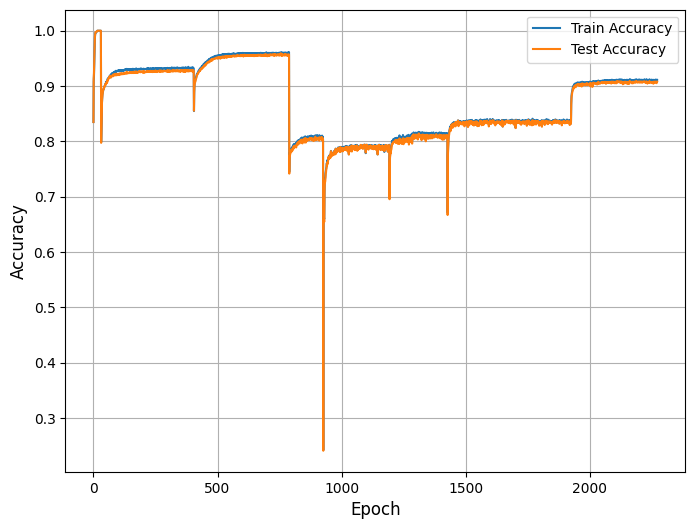

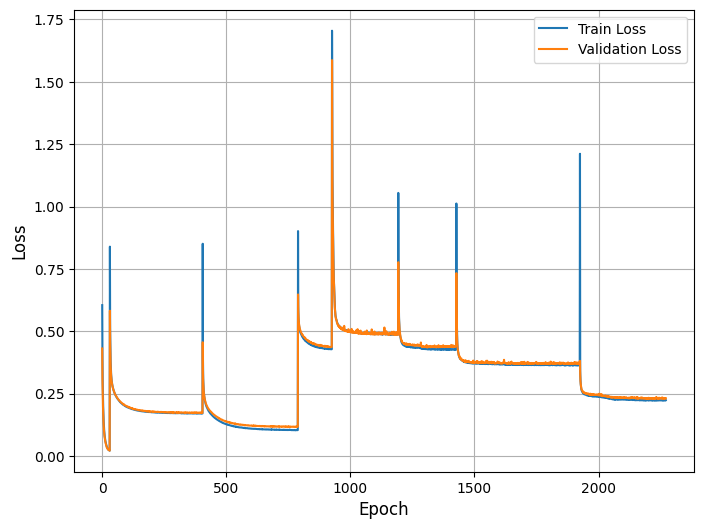

In [ ]:
plot_learning_curves(train_acc, test_acc, train_losses, val_losses, title="Dynamic Covtype Model Learning Curves")

In [ ]:
all_validation  = pd.concat(dfs_cov_all_validation, axis=0).sample(frac=1).reset_index(drop=True)
X_validation = torch.tensor(all_validation.drop(columns=['label']).values, dtype=torch.float32).to(device)
y_validation = torch.tensor(all_validation['label'].values, dtype=torch.long).to(device)
model_cov_dynamic.eval()
with torch.no_grad():
    val_preds = model_cov_dynamic(X_validation).argmax(dim=1)
    val_accuracy = accuracy_score(y_validation.cpu(), val_preds.cpu())
print(f"Dynamic Covtype Model Validation Accuracy: {val_accuracy:.4f}")


NameError: name 'model_cov_dynamic' is not defined

In [ ]:
# classification report for covtype baseline and dynamic
model_cov.eval()
with torch.no_grad(): 
    test_preds = model_cov(X_test_cov).argmax(dim=1)
    print("Classification Report for Baseline Covtype Model:")
    print(classification_report(y_test_cov.cpu(), test_preds.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_cov))]))

model_cov_dynamic.eval()
with torch.no_grad():
    test_preds = model_cov_dynamic(X_validation_cov).argmax(dim=1)
    # reverse mapping from mapped indices back to original labels
    reverse_label_map_cov = {v: k for k, v in label_map_cov.items()}
    # y_test_cov_scaled already contains mapped label indices (0..N-1), so use it directly
    mapped_y_test = y_validation_cov

    print("Classification Report for Dynamic Covtype Model:")
    print(classification_report(mapped_y_test.cpu(), test_preds.cpu(), 
                               target_names=[f"Class {reverse_label_map_cov[i]}" for i in range(len(label_map_cov))]))


Classification Report for Baseline Covtype Model:
              precision    recall  f1-score   support

     Class 0       0.80      0.76      0.78     63556
     Class 1       0.80      0.86      0.83     85078
     Class 2       0.78      0.81      0.79     10638
     Class 3       0.52      0.46      0.49       795
     Class 4       0.80      0.20      0.32      2941
     Class 5       0.61      0.50      0.55      5227
     Class 6       0.84      0.79      0.81      6069

    accuracy                           0.79    174304
   macro avg       0.73      0.63      0.65    174304
weighted avg       0.79      0.79      0.79    174304

Classification Report for Dynamic Covtype Model:
              precision    recall  f1-score   support

     Class 3       0.35      0.07      0.11     44636
     Class 4       0.59      0.51      0.55     59338
     Class 5       0.21      0.69      0.33      7542
     Class 6       0.00      0.00      0.00       601
     Class 2       0.00      0.00

/home/grant/Documents/University/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/grant/Documents/University/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/grant/Documents/University/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

In [ ]:
# Diagnostic checks: label distributions and prediction distributions
import numpy as np
print('Train shape:', df_train_cov_scaled.shape)
print('Validation shape:', df_validation_cov_scaled.shape)
print('Test shape:', df_test_cov_scaled.shape)

print('\nUnique labels:')
print('train unique:', np.sort(df_train_cov_scaled['label'].unique()))
print('val unique:', np.sort(df_validation_cov_scaled['label'].unique()))
print('test unique:', np.sort(df_test_cov_scaled['label'].unique()))

print('\nLabel counts (train):')
print(df_train_cov_scaled['label'].value_counts().sort_index())
print('\nLabel counts (val):')
print(df_validation_cov_scaled['label'].value_counts().sort_index())
print('\nLabel counts (test):')
print(df_test_cov_scaled['label'].value_counts().sort_index())

# Predictions distribution
model_cov.eval(); model_cov_dynamic.eval()
with torch.no_grad():
    base_preds = model_cov(X_test_cov).argmax(dim=1).cpu().numpy()
    dyn_preds = model_cov_dynamic(X_test_cov_scaled).argmax(dim=1).cpu().numpy()

print('\nBase model prediction counts:')
print(np.bincount(base_preds, minlength=len(label_map_cov)))
print('Most common base pred:', np.bincount(base_preds).argmax(), 'share:', np.bincount(base_preds).max()/len(base_preds))

print('\nDynamic model prediction counts:')
print(np.bincount(dyn_preds, minlength=len(label_map_cov)))
print('Most common dyn pred:', np.bincount(dyn_preds).argmax(), 'share:', np.bincount(dyn_preds).max()/len(dyn_preds))

# Scaler sanity
try:
    print('\nScaler mean (first 10):', np.round(scaler.mean_[:10], 4))
    print('Scaler scale (first 10):', np.round(scaler.scale_[:10], 4))
    print('\nSample X_train_cov_scaled mean (first 5 features across first 100 samples):')
    print(np.round(np.mean(X_train_cov_scaled[:100].numpy(), axis=0)[:10],4))
    print('Sample X_test_cov_scaled mean (first 5 features across first 100 samples):')
    print(np.round(np.mean(X_test_cov_scaled[:100].cpu().numpy(), axis=0)[:10],4))
except Exception as e:
    print('Scaler check error:', e)

# Check if any labels in test weren't present in train
train_labels = set(df_train_cov_scaled['label'].unique())
test_labels = set(df_test_cov_scaled['label'].unique())
print('\nTest labels not seen in train:', sorted(list(test_labels - train_labels)))


Train shape: (284696, 56)
Validation shape: (122012, 56)
Test shape: (174304, 56)

Unique labels:
train unique: [0 1 2 3 4 5 6]
val unique: [0 1 2 3 4 5 6]
test unique: [0 1 2 3 4 5 6]

Label counts (train):
label
0    103824
1    138580
2     17732
3      1324
4      4690
5      8467
6     10079
Name: count, dtype: int64

Label counts (val):
label
0    44213
1    59695
2     7504
3      567
4     2044
5     3685
6     4304
Name: count, dtype: int64

Label counts (test):
label
0    63803
1    85026
2    10518
3      856
4     2759
5     5215
6     6127
Name: count, dtype: int64

Base model prediction counts:
[60299 91453 11120   709   752  4320  5651]
Most common base pred: 1 share: 0.524675279970626

Dynamic model prediction counts:
[  2122    329    273      0  19774 124055  27751]
Most common dyn pred: 5 share: 0.7117163117312282

Scaler mean (first 10): [2.9588469e+03 1.4102500e+01 2.6888220e+02 4.6332900e+01 2.3468141e+03
 2.1204790e+02 2.2333350e+02 1.4265950e+02 1.9774108e+03 4.

In [ ]:
# Compute confusion matrices and per-class recall (validation and test) for baseline and dynamic models
from sklearn.metrics import confusion_matrix
import numpy as np

# Predictions already computed previously but recompute here to be safe
with torch.no_grad():
    val_preds_base = model_cov(X_validation_cov).argmax(dim=1).cpu().numpy()
    # For dynamic we used df_validation_cov_scaled rows; ensure exact alignment
    X_val_dyn = torch.tensor(df_validation_cov_scaled.drop(columns=['label']).values, dtype=torch.float32).to(device)
    val_preds_dyn = model_cov_dynamic(X_val_dyn).argmax(dim=1).cpu().numpy()

with torch.no_grad():
    test_preds_base = model_cov(X_test_cov).argmax(dim=1).cpu().numpy()
    test_preds_dyn = model_cov_dynamic(X_test_cov_scaled).argmax(dim=1).cpu().numpy()

# true labels (mapped indices)
# baseline y_validation_cov may be in a different order (train_test_split order) vs df_validation_cov_scaled; align carefully
# We will detect which label array matches predictions length and use those

def pick_labels_for(preds):
    # try candidates and pick the one with same length
    candidates = {}
    try:
        candidates['y_validation_cov'] = y_validation_cov.cpu().numpy()
    except Exception:
        pass
    try:
        candidates['df_validation_cov_scaled'] = df_validation_cov_scaled['label'].values
    except Exception:
        pass
    try:
        candidates['y_test_cov'] = y_test_cov.cpu().numpy()
    except Exception:
        pass
    for name, arr in candidates.items():
        if len(arr) == len(preds):
            return arr, name
    # fallback: return df_validation_cov_scaled if exists
    if 'df_validation_cov_scaled' in candidates:
        return candidates['df_validation_cov_scaled'], 'df_validation_cov_scaled'
    # last fallback
    return y_validation_cov.cpu().numpy(), 'y_validation_cov'

# pick aligned val labels for baseline + dynamic
y_val_base, name_base = pick_labels_for(val_preds_base)
y_val_dyn, name_dyn = pick_labels_for(val_preds_dyn)

# test labels
try:
    y_test = df_test_cov_scaled['label'].values
except Exception:
    y_test = y_test_cov.cpu().numpy()

# Build confusion matrices with labels range
labels = list(range(len(label_map_cov)))
cm_val_base = confusion_matrix(y_val_base, val_preds_base, labels=labels)
cm_val_dyn = confusion_matrix(y_val_dyn, val_preds_dyn, labels=labels)
cm_test_base = confusion_matrix(y_test, test_preds_base, labels=labels)
cm_test_dyn = confusion_matrix(y_test, test_preds_dyn, labels=labels)

# helper: per-class recall
def per_class_recall(cm):
    # cm rows: true class, cols: pred class
    with np.errstate(divide='ignore', invalid='ignore'):
        recall = np.diag(cm) / cm.sum(axis=1)
        recall[np.isnan(recall)] = 0.0
    return recall

rec_val_base = per_class_recall(cm_val_base)
rec_val_dyn = per_class_recall(cm_val_dyn)
rec_test_base = per_class_recall(cm_test_base)
rec_test_dyn = per_class_recall(cm_test_dyn)

print('Used val labels for baseline:', name_base)
print('Used val labels for dynamic:', name_dyn)
print('\nPer-class recall on validation (baseline):', np.round(rec_val_base,3))
print('Per-class recall on validation (dynamic):', np.round(rec_val_dyn,3))
print('\nPer-class recall on test (baseline):', np.round(rec_test_base,3))
print('Per-class recall on test (dynamic):', np.round(rec_test_dyn,3))

print('\nConfusion matrix (test, baseline):')
print(cm_test_base)
print('\nConfusion matrix (test, dynamic):')
print(cm_test_dyn)

results = {'cm_val_base':cm_val_base,'cm_val_dyn':cm_val_dyn,'cm_test_base':cm_test_base,'cm_test_dyn':cm_test_dyn,
           'rec_val_base':rec_val_base,'rec_val_dyn':rec_val_dyn,'rec_test_base':rec_test_base,'rec_test_dyn':rec_test_dyn}


Used val labels for baseline: y_validation_cov
Used val labels for dynamic: df_validation_cov_scaled

Per-class recall on validation (baseline): [0.758 0.857 0.813 0.473 0.222 0.486 0.799]
Per-class recall on validation (dynamic): [0.015 0.003 0.004 0.    0.253 0.389 0.29 ]

Per-class recall on test (baseline): [0.346 0.524 0.066 0.007 0.003 0.025 0.031]
Per-class recall on test (dynamic): [0.015 0.003 0.003 0.    0.27  0.377 0.316]

Confusion matrix (test, baseline):
[[22054 33608  4019   258   280  1571  2013]
 [29412 44519  5453   326   385  2124  2807]
 [ 3651  5482   695    49    28   268   345]
 [  317   429    49     6     4    18    33]
 [  966  1449   170    19     7    68    80]
 [ 1739  2800   317    26    20   129   184]
 [ 2160  3166   417    25    28   142   189]]

Confusion matrix (test, dynamic):
[[  959    17     1     0   504 46329 15993]
 [  795   253    39     0  5988 68343  9608]
 [    0    14    33     0  8486  1880   105]
 [    0     0     6     0   847     3    

In [ ]:
# Debugging label mappings and predictions
print("label_map_cov:", label_map_cov)
print("reverse_label_map_cov:", {v:k for k,v in label_map_cov.items()})
print("sorted_label_order_cov:", sorted_label_order_cov)
print("Unique y_test_cov:", torch.unique(y_test_cov))
print("Unique y_test_cov_scaled:", torch.unique(y_test_cov_scaled))
# show sample entries
print("y_test_cov[:20]:", y_test_cov[:20])
print("y_test_cov_scaled[:20]:", y_test_cov_scaled[:20])
# sample predictions
model_cov.eval()
model_cov_dynamic.eval()
with torch.no_grad():
    base_preds = model_cov(X_test_cov).argmax(dim=1)
    dyn_preds = model_cov_dynamic(X_test_cov_scaled).argmax(dim=1)
print("base_preds[:20]:", base_preds[:20])
print("dyn_preds[:20]:", dyn_preds[:20])
# check mapping attempt
try:
    mapped = torch.tensor([label_map_cov[label.item()] for label in y_test_cov_scaled], dtype=torch.long)
    print("mapped sample:", mapped[:20])
except Exception as e:
    print("Mapping error:", e)


label_map_cov: {np.int32(3): 0, np.int32(4): 1, np.int32(5): 2, np.int32(6): 3, np.int32(2): 4, np.int32(0): 5, np.int32(1): 6}
reverse_label_map_cov: {0: np.int32(3), 1: np.int32(4), 2: np.int32(5), 3: np.int32(6), 4: np.int32(2), 5: np.int32(0), 6: np.int32(1)}
sorted_label_order_cov: [np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(2), np.int32(0), np.int32(1)]
Unique y_test_cov: tensor([0, 1, 2, 3, 4, 5, 6])
Unique y_test_cov_scaled: tensor([0, 1, 2, 3, 4, 5, 6])
y_test_cov[:20]: tensor([0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 4, 1, 1, 0, 1, 4, 2, 1])
y_test_cov_scaled[:20]: tensor([1, 0, 0, 0, 0, 1, 6, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1])
base_preds[:20]: tensor([0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 5, 5])
dyn_preds[:20]: tensor([6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 4, 5, 5, 5])
mapped sample: tensor([6, 5, 5, 5, 5, 6, 3, 6, 5, 6, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6])


### Note on dynamic model evaluation
The dynamic model uses remapped label indices (0..N-1) stored in `y_test_cov_scaled` and the training/validation data. Previously the code attempted to remap `y_test_cov_scaled` again using `label_map_cov`, which double-mapped labels and produced incorrect label alignment. We now use `y_test_cov_scaled` directly as it already contains the mapped indices. `reverse_label_map_cov` is used only to display the original class labels in the report's `target_names` in the correct order.

In [ ]:
### Training for fashion mnist
input_dim_fashion = X_train_fashion.shape[1]
activation_fashion = optimal_params_fashion['activation']
model_fashion_dynamic = DynamicMLP(input_dim_fashion).to(device)
optimizer_fashion_dynamic = torch.optim.Adam(model_fashion_dynamic.parameters(), lr=optimal_params_fashion['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_complex_model(model_fashion_dynamic, optimizer_fashion_dynamic, criterion, optimal_params_fashion, dfs_fashion_all_train, dfs_fashion_all_validation, epochs=1000)
plot_learning_curves(train_acc, test_acc, title="Dynamic Fashion MNIST Model Learning Curves")
model_fashion_dynamic.print_structure()

In [ ]:
# classificatrion report for fashion baseline and dynamic
model_fashion.eval()
with torch.no_grad(): 
    test_preds = model_fashion(X_test_fashion).argmax(dim=1)
    print("Classification Report for Baseline Fashion MNIST Model:")
    print(classification_report(y_test_fashion.cpu(), test_preds.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))

model_fashion_dynamic.eval()
with torch.no_grad():
    test_preds = model_fashion_dynamic(X_test_fashion).argmax(dim=1)
    print("Classification Report for Dynamic Fashion MNIST Model:")
    print(classification_report(y_test_fashion.cpu(), test_preds.cpu(), target_names=[f"Class {i}" for i in range(len(label_map_fashion))]))


### Evaluation of baseline models and dynamic models

In [ ]:
runs = 3
results = {
    'baseline': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []},
    'dynamic': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
}

# Use existing dataset arrays and DataFrames available in the notebook
feature_cols_cov = df_covtype.drop('Cover_Type', axis=1).columns
num_classes_cov = len(df_covtype['Cover_Type'].unique())

input_dim = None
output_dim = None
hidden_layers = optimal_params_cov['hidden_layers']
activation = optimal_params_cov['activation']
lr = optimal_params_cov['lr']
epochs = 200  # per-run training epochs for baseline; dynamic will use same value for max epochs

for run in range(runs):
    print(f"Run {run+1}/{runs}")
    # different seed for different train/validation splits
    seed = 42 + run

    # --- Prepare per-run Covtype splits and scalers ---
    X_train_cov_init, X_test_cov_init, y_train_cov_init, y_test_cov_init = train_test_split(
        X_cov_type, y_cov_type, test_size=0.3, random_state=seed)
    X_train_cov_final, X_validation_cov_final, y_train_cov_final, y_validation_cov_final = train_test_split(
        X_train_cov_init, y_train_cov_init, test_size=0.3, random_state=seed)

    scaler = StandardScaler()
    X_train_cov_scaled = scaler.fit_transform(X_train_cov_final)
    X_validation_cov_scaled = scaler.transform(X_validation_cov_final)

    # build per-run DataFrames (same format as the rest of the notebook)
    df_train_cov_run = pd.DataFrame(X_train_cov_scaled, columns=feature_cols_cov)
    df_train_cov_run['label'] = y_train_cov_final
    df_validation_cov_run = pd.DataFrame(X_validation_cov_scaled, columns=feature_cols_cov)
    df_validation_cov_run['label'] = y_validation_cov_final

    # create per-class lists required by the dynamic training routine
    dfs_cov_all_train_run = [df_train_cov_run[df_train_cov_run['label'] == i].copy() for i in range(num_classes_cov)]
    dfs_cov_all_validation_run = [df_validation_cov_run[df_validation_cov_run['label'] == i].copy() for i in range(num_classes_cov)]

    # sort classes by size and relabel (keeps same logic as earlier in the notebook)
    dfs_cov_all_train_run.sort(key=lambda x: len(x), reverse=False)
    sorted_label_order_cov = [int(df['label'].iloc[0]) if len(df) > 0 else -1 for df in dfs_cov_all_train_run]
    # filter out empty classes (if any) and create mapping
    non_empty = [lbl for lbl in sorted_label_order_cov if lbl != -1]
    label_map_cov = dict(zip(non_empty, range(len(non_empty))))
    dfs_cov_all_train_run = [df.assign(label=label_map_cov[df['label'].iloc[0]]) for df in dfs_cov_all_train_run if len(df) > 0]
    dfs_cov_all_validation_run = [df_validation_cov_run[df_validation_cov_run['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in non_empty]

    # create tensors for baseline training / validation
    X_train_cov_run = torch.tensor(df_train_cov_run.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_train_cov_run = torch.tensor(df_train_cov_run['label'].values, dtype=torch.long).to(device)
    X_validation_cov_run = torch.tensor(df_validation_cov_run.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_validation_cov_run = torch.tensor(df_validation_cov_run['label'].values, dtype=torch.long).to(device)

    input_dim = X_train_cov_run.shape[1]
    output_dim = len(torch.unique(y_train_cov_run))

    # --- Baseline SimpleMLP trained on per-run tensors ---
    baseline_model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
    opt_b = torch.optim.Adam(baseline_model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    t0 = time.time()
    baseline_model.train()
    for ep in range(epochs):
        opt_b.zero_grad()
        out = baseline_model(X_train_cov_run)
        loss = crit(out, y_train_cov_run)
        loss.backward()
        opt_b.step()
    t1 = time.time()

    baseline_model.eval()
    with torch.no_grad():
        val_preds = baseline_model(X_validation_cov_run).argmax(dim=1)
        acc = accuracy_score(y_validation_cov_run.cpu(), val_preds.cpu())
        prec = precision_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        rec = recall_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        f1 = f1_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)

    results['baseline']['accuracy'].append(acc)
    results['baseline']['precision'].append(prec)
    results['baseline']['recall'].append(rec)
    results['baseline']['f1'].append(f1)
    results['baseline']['time'].append(t1 - t0)

    print(f"Baseline run {run+1}: val_acc={acc:.4f}, prec={prec:.4f}, recall={rec:.4f}, f1={f1:.4f}, time={t1-t0:.2f}s")

    # --- Dynamic model using per-run per-class DataFrames ---
    dyn_model = DynamicMLP(input_dim).to(device)
    opt_d = torch.optim.Adam(dyn_model.parameters(), lr=lr)

    t0 = time.time()
    # train_complex_model will operate on per-class DataFrames
    train_acc_list, val_acc_list = train_complex_model(
        dyn_model, opt_d, crit, optimal_params_cov,
        dfs_cov_all_train_run, dfs_cov_all_validation_run,
        label='label', epochs=epochs
    )
    t1 = time.time()

    # evaluate dynamic model on the same validation tensors
    dyn_model.eval()
    with torch.no_grad():
        val_preds_d = dyn_model(X_validation_cov_run).argmax(dim=1)
        acc_d = accuracy_score(y_validation_cov_run.cpu(), val_preds_d.cpu())
        prec_d = precision_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)
        rec_d = recall_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)
        f1_d = f1_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)

    results['dynamic']['accuracy'].append(acc_d)
    results['dynamic']['precision'].append(prec_d)
    results['dynamic']['recall'].append(rec_d)
    results['dynamic']['f1'].append(f1_d)
    results['dynamic']['time'].append(t1 - t0)

    print(f"Dynamic run {run+1}: val_acc={acc_d:.4f}, prec={prec_d:.4f}, recall={rec_d:.4f}, f1={f1_d:.4f}, time={t1-t0:.2f}s")
    print("---")

# End runs
print('\nAll runs complete.')


In [ ]:
# Ensure results directory exists
os.makedirs(results_dir, exist_ok=True)

# build summary DataFrame
rows = []
for model_name in ['baseline', 'dynamic']:
    row = {'model': model_name}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'time']:
        vals = results[model_name][metric]
        row[f'{metric}_mean'] = np.mean(vals) if len(vals) > 0 else np.nan
        row[f'{metric}_std'] = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
    rows.append(row)

summary_df = pd.DataFrame(rows)
# nicer ordering
cols = ['model'] + [c for m in ['accuracy', 'precision', 'recall', 'f1', 'time'] for c in (f'{m}_mean', f'{m}_std')]
summary_df = summary_df[cols]
print('\nCross-validation summary (means and std):')
print(summary_df)

# Save per-run results and summary to CSV
per_run_rows = []
for model_name in ['baseline', 'dynamic']:
    for i in range(len(results[model_name]['accuracy'])):
        per_run_rows.append({
            'model': model_name,
            'run': i+1,
            'accuracy': results[model_name]['accuracy'][i],
            'precision': results[model_name]['precision'][i],
            'recall': results[model_name]['recall'][i],
            'f1': results[model_name]['f1'][i],
            'time': results[model_name]['time'][i]
        })
per_run_df = pd.DataFrame(per_run_rows)
per_run_csv = os.path.join(results_dir, 'evaluation_per_run.csv')
per_run_df.to_csv(per_run_csv, index=False)
print(f"Per-run results saved to: {per_run_csv}")

summary_csv = os.path.join(results_dir, 'evaluation_summary.csv')
summary_df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

# Also append to a master evaluation file (creates if not present)
master_csv = os.path.join(results_dir, 'evaluation_results.csv')
# create master file with headers if it doesn't exist
if not os.path.exists(master_csv):
    summary_df.to_csv(master_csv, index=False)
else:
    # append with a header only if file is empty
    summary_df.to_csv(master_csv, mode='a', header=False, index=False)
print(f"Appended summary to master file: {master_csv}")

# Final classification reports on the shared TEST set
print('\nClassification reports on shared TEST set:')
# Baseline final model: retrain baseline on full training+validation (to make final test evaluation fair)
print('\nRetraining baseline on train+validation and evaluating on TEST set...')
# combine training and validation into one set (use last run's splits as representative)
X_full_train = torch.cat([X_train_cov_run, X_validation_cov_run], dim=0)
Y_full_train = torch.cat([y_train_cov_run, y_validation_cov_run], dim=0)

final_baseline = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
opt_fb = torch.optim.Adam(final_baseline.parameters(), lr=lr)
final_baseline.train()
for ep in range(epochs):
    opt_fb.zero_grad()
    out = final_baseline(X_full_train)
    loss = crit(out, Y_full_train)
    loss.backward()
    opt_fb.step()
final_baseline.eval()
with torch.no_grad():
    test_preds_b = final_baseline(X_test_cov).argmax(dim=1)
print('\nBaseline TEST classification report:')
report_b = classification_report(y_test_cov.cpu(), test_preds_b.cpu(), zero_division=0, output_dict=True)
print(classification_report(y_test_cov.cpu(), test_preds_b.cpu(), zero_division=0))

# save baseline report
baseline_report_file = os.path.join(results_dir, 'baseline_test_classification_report.json')
with open(baseline_report_file, 'w') as f:
    json.dump(report_b, f, indent=2)
print(f"Baseline test classification report saved to: {baseline_report_file}")


In [ ]:
# Dynamic final model: retrain with train_complex_model on dfs_cov_all_train + dfs_cov_all_validation (the splits already used), then evaluate on same X_test_cov
print('\nTraining dynamic model on train+validation (per-class) and evaluating on TEST set...')
final_dynamic = DynamicMLP(input_dim).to(device)
opt_fd = torch.optim.Adam(final_dynamic.parameters(), lr=lr)
# train using the per-run per-class data we created earlier (dfs_cov_all_train_run/validation)
train_complex_model(final_dynamic, opt_fd, crit, optimal_params_cov, dfs_cov_all_train_run, dfs_cov_all_validation_run, label='label', epochs=epochs)
final_dynamic.eval()
with torch.no_grad():
    test_preds_d = final_dynamic(X_test_cov).argmax(dim=1)
print('\nDynamic TEST classification report:')
report_d = classification_report(y_test_cov.cpu(), test_preds_d.cpu(), zero_division=0, output_dict=True)
print(classification_report(y_test_cov.cpu(), test_preds_d.cpu(), zero_division=0))

# save dynamic report
dynamic_report_file = os.path.join(results_dir, 'dynamic_test_classification_report.json')
with open(dynamic_report_file, 'w') as f:
    json.dump(report_d, f, indent=2)
print(f"Dynamic test classification report saved to: {dynamic_report_file}")

# Append a combined row to master CSV with timestamps and paths for artifacts
timestamp = pd.Timestamp.now().isoformat()
combined_row = {
    'timestamp': timestamp,
    'dataset': 'covtype',
    'runs': runs,
    'baseline_summary_path': summary_csv,
    'per_run_path': per_run_csv,
    'baseline_report': baseline_report_file,
    'dynamic_report': dynamic_report_file
}
combined_df = pd.DataFrame([combined_row])
master_meta_csv = os.path.join(results_dir, 'evaluation_runs_meta.csv')
if not os.path.exists(master_meta_csv):
    combined_df.to_csv(master_meta_csv, index=False)
else:
    combined_df.to_csv(master_meta_csv, mode='a', header=False, index=False)
print(f"Evaluation metadata appended to: {master_meta_csv}")


In [ ]:
summary_df